In [1]:
# Setup

try:
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    !git clone https://github.com/Kamaropoulos/one-pixel-attack-keras.git
    !mv -v one-pixel-attack-keras/* .
    !rm -rf one-pixel-attack-keras

# Python Libraries
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10
from keras import backend as K

# Custom Networks
from networks.sigmanet import SigmaNet

# Helper functions
from differential_evolution import differential_evolution
import helper

from PIL import Image

matplotlib.style.use('ggplot')
np.random.seed(100)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

/home/hyper/Documents/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
def perturb_image(xs, img, logPixel=False):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            if logPixel:
              print(','.join(map(str, pixel)))
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs

def predict_classes(xs, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, img)

    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)
    
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if verbose:
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True
    # NOTE: return None otherwise (not False), due to how Scipy handles its callback function

In [ ]:
def attack(image, model, source=None, target=None, pixel_count=1, 
           maxiter=75, popsize=400, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else source

    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, image, target_class, 
                               model, target is None)
    
    def callback_fn(x, convergence):
        return attack_success(x, image, target_class, 
                              model, targeted_attack, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)

    # Calculate some useful statistics to return from this function
    attack_image = perturb_image(attack_result.x, image, True)[0]
    prior_probs = model.predict_one(image)
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = source
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    # Show the best attempt at a solution (successful or not)
    helper.plot_image(attack_image, actual_class, class_names, predicted_class)

    return [model.name, pixel_count, 0, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result.x]

In [ ]:
# Instantiate SigmaNet model
sigmanet = SigmaNet()

In [ ]:
# Load image
image = Image.open('attack_images/dog.png').convert('RGB')
# Convert to numpy array
image = np.array(image)

Confidence: 0.7792326
Confidence: 0.7792326
Confidence: 0.7792326
Confidence: 0.58617187
Confidence: 0.58617187
Confidence: 0.58617187
Confidence: 0.5463879
Confidence: 0.5463879
Confidence: 0.40215665


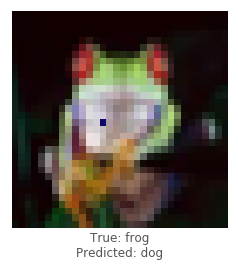

In [15]:
pixels = 5 # Number of pixels to attack

_ = attack(image, sigmanet, pixel_count=pixels, verbose=True)

Attacking with target automobile
Confidence: 0.072408296
Confidence: 0.072408296
Confidence: 0.072408296
Confidence: 0.072408296
Confidence: 0.072408296
Confidence: 0.072408296
Confidence: 0.072408296
Confidence: 0.104250394
Confidence: 0.104250394
Confidence: 0.104250394
Confidence: 0.104250394
Confidence: 0.104250394
Confidence: 0.104250394
Confidence: 0.104250394
Confidence: 0.28965676
Confidence: 0.28965676
Confidence: 0.28965676
Confidence: 0.28965676
Confidence: 0.28965676
Confidence: 0.28965676
Confidence: 0.28965676
Confidence: 0.28965676
Confidence: 0.28965676
Confidence: 0.28965676
Confidence: 0.28965676
Confidence: 0.28965676
Confidence: 0.28965676
Confidence: 0.30170715
Confidence: 0.42491597
Confidence: 0.42491597
Confidence: 0.42491597
Confidence: 0.47848365
Confidence: 0.47848365
Confidence: 0.5053054


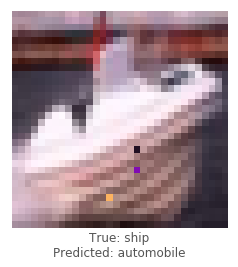

In [16]:
image_id = 108
target_class = 1 # Integer in range 0-9
pixels = 3
model = lenet

print('Attacking with target', class_names[target_class])
_ = attack(image_id, model, target_class, pixel_count=pixels, verbose=True)